In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import resample, shuffle
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
    ExtraTreesClassifier,
)
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    make_scorer,
)
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform, randint
from tqdm import tqdm
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve

# Display rows and columns
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_colwidth", 300)

# Display all outputs
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "last_expr"

# format code
import jupyter_black

jupyter_black.load()
DIRECTORY = "../../data/"

In [2]:
dataset = pd.read_csv(DIRECTORY + "2015.csv")

In [3]:
dataset.shape

(441456, 330)

In [4]:
data = dataset.round().copy()  # MIKES Modified
# remove observations where _MICHD is missing
data = data[~data["_MICHD"].isna()]
data["_MICHD"].value_counts()

2.0    398881
1.0     38633
Name: _MICHD, dtype: int64

The _MICHD variable indicates if a patient has had either mycardial infarction (heart attack) or coronary heart disease. This is an engineered feature in the original dataset that was derived from features CVDINFR4 and CVDCRHD4. 
1. CVDINFR4: have you ever had a heart attack, also called a myocardial infarction (MI)? 
2. CVDCRHD4: have you ever been diagnosed with angina or coronary heart disease (CHD)?

Target classes:
- Class 1: Reported having MI or CHD (CVDINFR4=1 OR CVDCRHD4=1)
- Class 2: Did not report having MI or CHD (CVDINFR4=2 OR CVDCRHD4=2)
Blank/NA: Not asked or missing (CVDINFR4=7, 9 OR MISSING OR CVDCRHD4=7, 9, OR MISSING)

We have dropped the observations with an _MICHD value of NaN for the 2015 dataset. 

In [5]:
# recode target variable: 0 no heart disease, 1 heart disease
data["_MICHD"] = data["_MICHD"].map(lambda x: 0 if x == 2 else 1)
# drop "CVDINFR4", "CVDCRHD4", since these were used to engineer the _MICHD target
data = data.drop(["CVDINFR4", "CVDCRHD4"], axis=1)

### Balance the dataset:
- a) Remove columns with greater than 30% missingness
- b) Remove rows with missing values (any amount) where "_MICHD" = 0 (no heart disese)
- c) Downsample "_MICHD" = 0 to equal rows in "_MICHD" = 1

In [6]:
# a) Remove columns with greater than 30% missingness

# calculate the percentage of missing values in each column
missing_percentage = (data.isnull().sum() / len(data)) * 100

# create a new DataFrame to display the results
data_missing = pd.DataFrame(
    {
        "Column": missing_percentage.index,
        "missing_percentage": missing_percentage.values,
    }
)

# get columns with greater than 30% missingness
data_missing = data_missing[data_missing["missing_percentage"] > 30].sort_values(
    by="missing_percentage", ascending=False
)

data_missing.head()

,Column,missing_percentage
121,QLHLTH2,100.000000
118,PAINACT2,100.000000
119,QLMENTL2,100.000000
120,QLSTRES2,100.000000
11,COLGHOUS,99.989715


In [7]:
# remove columns with greater than 30% missingness
selected_columns = data.columns.difference(data_missing["Column"].values.tolist())
data_removed_30_threshold = (data[selected_columns]).copy()

data_removed_30_threshold.shape

(437514, 148)

In [8]:
# b) Remove rows with missing values (any amount) where "_MICHD" = 0 (no heart disese)

# Create column with calculaated number of NaN in the row
data_removed_30_threshold["number_rows_NaN"] = data_removed_30_threshold.isna().sum(
    axis=1
)

# removal using loc to select rows based on the condition
condition = (data_removed_30_threshold["_MICHD"] == 0) & (
    data_removed_30_threshold["number_rows_NaN"] != 0
)

data_removed_30_threshold.drop(
    data_removed_30_threshold.loc[condition].index, inplace=True
)

In [9]:
data_removed_30_threshold["_MICHD"].value_counts()

0    195133
1     38633
Name: _MICHD, dtype: int64

In [10]:
data_removed_30_threshold[data_removed_30_threshold["number_rows_NaN"] == 0][
    "_MICHD"
].value_counts()

0    195133
1     20694
Name: _MICHD, dtype: int64

In [11]:
data_removed_30_threshold[data_removed_30_threshold["number_rows_NaN"] != 0][
    "_MICHD"
].value_counts()

1    17939
Name: _MICHD, dtype: int64

In [12]:
# Drop the 'number_rows_NaN' column as it was auxiliary and temporal
data_removed_30_threshold.drop(columns=["number_rows_NaN"], inplace=True)

In [13]:
data_removed_30_threshold.shape

(233766, 148)

In [14]:
# c) Downsample "_MICHD" = 0 to equal rows in "_MICHD" = 1

data_1 = data_removed_30_threshold[
    data_removed_30_threshold["_MICHD"] == 1
]  # heart disease
data_0 = data_removed_30_threshold[
    data_removed_30_threshold["_MICHD"] == 0
]  # no heart disease
data_0_downsample = data_0.sample(
    n=38633, replace=False, random_state=42
)  # same number of observations as those with heart disease
data_balanced = pd.concat([data_1, data_0_downsample], ignore_index=True)
data_balanced["_MICHD"].value_counts()

1    38633
0    38633
Name: _MICHD, dtype: int64

In [15]:
len(data_balanced.columns)

148

We manually reviewed the remaining 148 features, dropping features that most likely had no significance in predicting heart disease (e.g. IDATE, interview date), and recoding the remaining columns to play nicely with machine learning models. 

In [16]:
drop = [
    "FRUITJU1",
    "FRUTDA1_",
    "FTJUDA1_",
    "FVBEANS",
    "FVGREEN",
    "FVORANG",
    "HEIGHT3",
    "HIVTST6",
    "IDATE",
    "IDAY",
    "IMONTH",
    "INCOME2",
    "INTERNET",
    "IYEAR",
    "PAMISS1_",
    "HTM4",
    "_AGEG5YR",
    "PCDMDECN",
    # Marinus
    "_RAWRAKE",
    "_STATE",
    "_STRWT",
    "_STSTR",
    "_VEG23",
    "_VEGETEX",
    "_VEGRESP",
    "_WT2RAKE",
    # Mihir
    "QSTVER",
    "WEIGHT2",
    "SEATBELT",
    "SEQNO",
    "_CASTHM1",
    "_DUALUSE",
    # Miguel
    "_LLCPWT",
    "_FRUTSUM",
    # Amir
    "EXACTOT1",
    "EXACTOT2",
]
keep = selected_columns.difference(drop)
len(keep)

112

In [17]:
filtered_data = data_balanced[keep].copy()

In [18]:
filtered_data["HAVARTH3"] = filtered_data["HAVARTH3"].replace({2: 0, 7: np.nan, 9: np.nan})
filtered_data["HLTHPLN1"] = filtered_data["HLTHPLN1"].replace({2: 0, 7: np.nan, 9: np.nan})
filtered_data["MARITAL"] = filtered_data["MARITAL"].replace({9: np.nan})
filtered_data["MEDCOST"] = filtered_data["MEDCOST"].replace({2: 0, 7: np.nan, 9: np.nan})
filtered_data["MENTHLTH"] = filtered_data["MENTHLTH"].replace({88: 0, 77: np.nan, 99: np.nan})
filtered_data["PERSDOC2"] = filtered_data["PERSDOC2"].replace({7: np.nan, 9: np.nan})
filtered_data["WTKG3"] = filtered_data["WTKG3"].replace({99999: np.nan})
filtered_data["CHCCOPD1"] = filtered_data["CHCCOPD1"].replace({2: 0, 7: np.nan, 9: np.nan})
filtered_data["_INCOMG"] = filtered_data["_INCOMG"].replace({9: np.nan})
filtered_data["TOLDHI2"] = filtered_data["TOLDHI2"].replace({7: np.nan, 9: np.nan})
filtered_data["DIFFWALK"] = filtered_data["DIFFWALK"].replace({2: 0, 7: np.nan, 9: np.nan})
filtered_data["_LMTSCL1"] = filtered_data["_LMTSCL1"].replace({9: np.nan})
filtered_data["_RFCHOL"] = filtered_data["_RFCHOL"].replace({1: 0, 2: 1, 9: np.nan})
filtered_data["QLACTLM2"] = filtered_data["QLACTLM2"].replace({2: 0, 7: np.nan, 9: np.nan})
filtered_data["PNEUVAC3"] = filtered_data["PNEUVAC3"].replace({2: 0, 7: np.nan, 9: np.nan})
filtered_data["FC60_"] = filtered_data["FC60_"].replace({99900: np.nan})
filtered_data["CHILDREN"] = filtered_data["CHILDREN"].replace({88: 0, 99: np.nan})
filtered_data["CVDSTRK3"] = filtered_data["CVDSTRK3"].replace({2: 0, 7: np.nan, 9: np.nan})
filtered_data["DIABETE3"] = filtered_data["DIABETE3"].replace({7: np.nan, 9: np.nan})
filtered_data["_AGE65YR"] = filtered_data["_AGE65YR"].replace({3: np.nan})
filtered_data["MAXVO2_"] = filtered_data["MAXVO2_"].replace({99900: np.nan})
physhlth_median = filtered_data["PHYSHLTH"].median()
filtered_data["PHYSHLTH"] = filtered_data["PHYSHLTH"].replace({88: 0, 77: np.nan, 99: np.nan})
filtered_data["_RFHYPE5"] = filtered_data["_RFHYPE5"].replace({1: 0, 2: 1, 9: np.nan})
filtered_data["_RFHLTH"] = filtered_data["_RFHLTH"].replace({9: np.nan})
filtered_data["SEX"] = filtered_data["SEX"].replace({2: 0, 9: np.nan})
filtered_data["_DRDXAR1"] = filtered_data["_DRDXAR1"].replace({2: 0})
filtered_data["BPHIGH4"] = filtered_data["BPHIGH4"].replace({7: np.nan, 9: np.nan})
filtered_data["GENHLTH"] = filtered_data["GENHLTH"].replace({7: np.nan, 9: np.nan})
filtered_data["_HCVU651"] = filtered_data["_HCVU651"].replace({2: 0, 9: np.nan})
filtered_data["EMPLOY1"] = filtered_data["EMPLOY1"].replace({9: np.nan})
filtered_data["_VEGLT1"] = filtered_data["_VEGLT1"].replace({9: np.nan})

In [19]:
filtered_data["_FRTLT1"] = filtered_data["_FRTLT1"].replace({2: 0})
filtered_data["_HISPANC"] = filtered_data["_HISPANC"].replace({2: 0})
filtered_data["_LTASTH1"] = filtered_data["_LTASTH1"].replace({1: 0, 2: 1})

In [20]:
filtered_data["_PAINDX1"] = filtered_data["_PAINDX1"].replace({2: 0})
filtered_data["_PASTAE1"] = filtered_data["_PASTAE1"].replace({2: 0})
filtered_data["_PASTRNG"] = filtered_data["_PASTRNG"].replace({2: 0})

my_list = [
    "_EDUCAG",
    "_FRT16",
    "_FRTLT1",
    "_FRTRESP",
    "_FRUITEX",
    "_HISPANC",
    "_LMTACT1",
    "_LMTWRK1",
    "_LTASTH1",
    "_MISFRTN",
    "_MISVEGN",
    "_MRACE1",
    "_PA150R2",
    "_PA30021",
    "_PA300R2",
    "_PACAT1",
    "_PAINDX1",
    "_PAREC1",
    "_PASTAE1",
    "_PASTRNG",
    "_PRACE1",
]

for item in my_list:
    filtered_data[item] = filtered_data[item].replace(
        {9: np.nan, 99: np.nan, 77: np.nan}
    )

In [21]:
# Amir's columns
my_list = [
    "ADDEPEV2",
    "ALCDAY5",
    "ASTHMA3",
    "BEANDAY_",
    "BLIND",
    "BLOODCHO",
    "CHCKIDNY",
    "CHCOCNCR",
    "CHCSCNCR",
    "CHECKUP1",
    "CHOLCHK",
    "DECIDE",
    "DIFFALON",
    "DIFFDRES",
    "DISPCODE",
    "DRNKANY5",
    "DROCDY3_",
    "EDUCA",
    "EXERANY2",
    "FLUSHOT6",
    "FRUIT1",
]
excluded = ["BEANDAY_", "DROCDY3_"]
clean_7 = [item for item in my_list if item not in excluded]

for item in clean_7:
    filtered_data[item] = filtered_data[item].replace({7: np.nan})

clean_777 = ["FRUIT1", "ALCDAY5"]

for item in clean_777:
    filtered_data[item] = filtered_data[item].replace({777: np.nan})

excluded = ["DROCDY3_", "ALCDAY5", "FRUIT1"]
clean_9 = [item for item in my_list if item not in excluded]

for item in clean_9:
    filtered_data[item] = filtered_data[item].replace({9: np.nan})

clean_999 = ["FRUIT1", "ALCDAY5"]

for item in clean_999:
    filtered_data[item] = filtered_data[item].replace({999: np.nan})

clean_900 = ["DROCDY3_"]

for item in clean_900:
    filtered_data[item] = filtered_data[item].replace({900: np.nan})


def convert_to_times_per_month(df, column_name, conversion_rules):
    """
    Convert values in a DataFrame column based on specified rules.

    Parameters:
    - df: pandas DataFrame
    - column_name: Name of the column to be converted
    - conversion_rules: Dictionary containing conversion rules with the format:
                       {'category': (lower_bound, upper_bound, factor, interceptor), ...}

    Returns:
    - DataFrame with the specified column values converted according to the rules
    """
    # Apply the conversion rules
    for category, (
        lower_bound,
        upper_bound,
        factor,
        interceptor,
    ) in conversion_rules.items():
        mask = df[column_name].between(lower_bound, upper_bound)
        df.loc[mask, column_name] = (df.loc[mask, column_name] - interceptor) * factor

    return df


# Define the conversion rules
my_conversion_rules = {
    "Times per day": (101, 199, 30, 100),
    "Times per week": (201, 299, 4.33, 200),
    "Times per month": (301, 399, 1, 300),
    "Never 300": (300, 300, 0, 300),
    "Never 555": (555, 555, 0, 500),
}


# Convert values in the 'FRUIT1' column using the custom conversion rules
convert_to_times_per_month(filtered_data, "FRUIT1", my_conversion_rules)

# Define the conversion rules to convert all to days per month
my_conversion_rules = {
    "Days per week": (101, 199, 4.33, 100),
    "Days in past 30 days": (201, 299, 1, 200),
    "No drinks in past 30 days": (888, 888, 0, 888),
}

# Convert values in the 'FRUIT1' column using the custom conversion rules
convert_to_times_per_month(filtered_data, "ALCDAY5", my_conversion_rules)

binaries = [
    "ADDEPEV2",
    "ASTHMA3",
    "BLIND",
    "BLOODCHO",
    "CHCKIDNY",
    "CHCOCNCR",
    "CHCSCNCR",
    "DECIDE",
    "DIFFALON",
    "DIFFDRES",
    "DRNKANY5",
    "EXERANY2",
    "FLUSHOT6",
]

for item in binaries:
    filtered_data[item] = filtered_data[item].replace({2: 0})

In [22]:
# Mihir's columns
# cleaning STRENGTH (convert responses to times/month)

filtered_data["STRENGTH"] = filtered_data.apply(
    lambda row: round((row["STRENGTH"] - 100) * 4.3)
    if 100 <= row["STRENGTH"] <= 199
    else row["STRENGTH"],
    axis=1,
)
filtered_data["STRENGTH"] = filtered_data.apply(
    lambda row: (row["STRENGTH"] - 200)
    if 200 <= row["STRENGTH"] <= 299
    else row["STRENGTH"],
    axis=1,
)

# set all blank, missing, unknown, refused, unsure, etc. values to NaN
filtered_data.loc[filtered_data["QSTLANG"] >= 3, "QSTLANG"] = np.nan
filtered_data.loc[filtered_data["RENTHOM1"] >= 4, "RENTHOM1"] = np.nan
filtered_data.loc[filtered_data["SMOKE100"] >= 3, "SMOKE100"] = np.nan
filtered_data.loc[filtered_data["USEEQUIP"] >= 3, "USEEQUIP"] = np.nan
filtered_data.loc[filtered_data["USENOW3"] >= 4, "USENOW3"] = np.nan
filtered_data.loc[filtered_data["VETERAN3"] >= 3, "VETERAN3"] = np.nan
filtered_data.loc[filtered_data["_AIDTST3"] >= 3, "_AIDTST3"] = np.nan
filtered_data.loc[filtered_data["_ASTHMS1"] >= 4, "_ASTHMS1"] = np.nan
filtered_data.loc[filtered_data["_BMI5CAT"] > 4, "_BMI5CAT"] = np.nan
filtered_data.loc[filtered_data["_CHISPNC"] > 2, "_CHISPNC"] = np.nan
filtered_data.loc[filtered_data["_CHLDCNT"] > 6, "_CHLDCNT"] = np.nan
filtered_data.loc[filtered_data["_CHOLCHK"] > 3, "_CHOLCHK"] = np.nan
filtered_data.loc[filtered_data["_DRNKWEK"] > 98999, "_DRNKWEK"] = np.nan
filtered_data.loc[filtered_data["STRFREQ_"] > 98999, "STRFREQ_"] = np.nan
filtered_data.loc[filtered_data["STRENGTH"] >= 777, "STRENGTH"] = np.nan

In [23]:
# categorical: missing values will be replaced with the mode.
categorical = [
    "HAVARTH3",
    "HLTHPLN1",
    "MARITAL",
    "MEDCOST",
    "PERSDOC2",
    "CHCCOPD1",
    "_INCOMG",
    "TOLDHI2",
    "DIFFWALK",
    "_LMTSCL1",
    "_RFCHOL",
    "QLACTLM2",
    "PNEUVAC3",
    "CVDSTRK3",
    "DIABETE3",
    "_AGE65YR",
    "_RFHYPE5",
    "_RFHLTH",
    "SEX",
    "_DRDXAR1",
    "BPHIGH4",
    "_AGE_G",
    "_AGE80",
    "GENHLTH",
    "_HCVU651",
    "EMPLOY1",
    "_RACE",
    "_RACEG21",
    "_RACEGR3",
    "_RACE_G1",
    "_RFBING5",
    "_RFBMI5",
    "_RFDRHV5",
    "_RFSEAT2",
    "_RFSEAT3",
    "_RFSMOK3",
    "_SMOKER3",
    "_TOTINDA",
    "_VEGLT1",
    "QSTLANG",
    "RENTHOM1",
    "SMOKE100",
    "USEEQUIP",
    "USENOW3",
    "VETERAN3",
    "_AIDTST3",
    "_ASTHMS1",
    "_BMI5CAT",
    "_CHISPNC",
    "_CHLDCNT",
    "_CHOLCHK",
    "_EDUCAG",
    "_FRT16",
    "_FRTLT1",
    "_FRTRESP",
    "_FRUITEX",
    "_HISPANC",
    "_LMTACT1",
    "_LMTWRK1",
    "_LTASTH1",
    "_MISFRTN",
    "_MISVEGN",
    "_MRACE1",
    "_PA150R2",
    "_PA30021",
    "_PA300R2",
    "_PACAT1",
    "_PAINDX1",
    "_PAREC1",
    "_PASTAE1",
    "_PASTRNG",
    "_PRACE1",
    "ADDEPEV2",
    "ASTHMA3",
    "BLIND",
    "BLOODCHO",
    "CHCKIDNY",
    "CHCOCNCR",
    "CHCSCNCR",
    "CHECKUP1",
    "CHOLCHK",
    "DECIDE",
    "DIFFALON",
    "DIFFDRES",
    "DISPCODE",
    "DRNKANY5",
    "EDUCA",
    "EXERANY2",
    "FLUSHOT6",
]
# continuous: missing values will be replaced with the median. These need to be scaled.
continuous = [
    "GRENDAY_",
    "MENTHLTH",
    "ORNGDAY_",
    "HTIN4",
    "WTKG3",
    "FC60_",
    "CHILDREN",
    "MAXVO2_",
    "PHYSHLTH",
    "_VEGESUM",
    "_DRNKWEK",
    "STRFREQ_",
    "VEGEDA1_",
    "VEGETAB1",
    "STRENGTH",
    "_BMI5",
    "DROCDY3_",
    "BEANDAY_",
    "ALCDAY5",
    "FRUIT1",
]

target = ["_MICHD"]

In [24]:
len(categorical) + len(continuous)

109

In [25]:
# for any remaining columns that haven't been recoded
for column in categorical:
    filtered_data[column].replace({9: filtered_data[column].mode()[0]}, inplace=True)

In [26]:
filtered_data.dropna(subset=target, inplace=True)
y = filtered_data[target]
X = filtered_data.drop(target, axis=1)

In [27]:
X.shape

(77266, 111)

In [28]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

cat_pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="most_frequent")),
    ]
)


num_pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
    ]
)

full_pipeline = ColumnTransformer(
    [
        ("num", num_pipeline, continuous),
        ("cat", cat_pipeline, categorical),
    ]
)

In [29]:
full_pipeline.fit(X)
# Transform data and convert it back to a DataFrame with column names
X_transform = pd.DataFrame(
    full_pipeline.transform(X),
    columns=continuous
    + full_pipeline.named_transformers_["cat"]
    .get_feature_names_out(categorical)
    .tolist(),
)

In [30]:
# implement ExtraTrees to quickly identify feature importance
clf = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf.fit(X_transform, y)

# https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#sphx-glr-auto-examples-ensemble-plot-forest-importances-py
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)

/var/folders/1_/8tjkkw0s5k7bhzr96pfx40dr0000gn/T/ipykernel_35283/4041055153.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_transform, y)


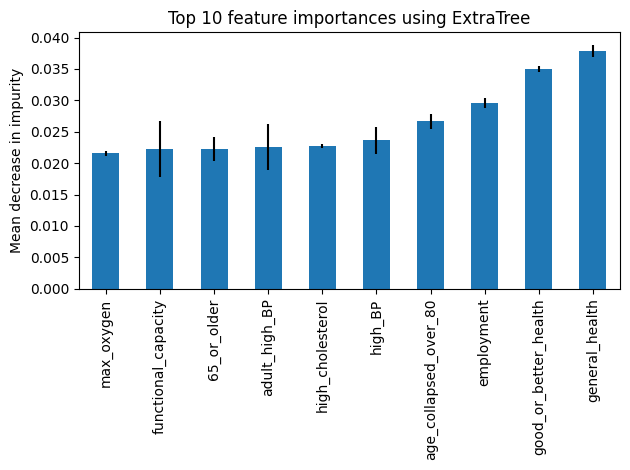

In [31]:
# plot top 10 most important features
forest_importances = pd.Series(importances, index=X_transform.columns).sort_values()[
    -10:
]
forest_importances.rename(
    {
        "MAXVO2_": "max_oxygen",
        "FC60_": "functional_capacity",
        "_AGE65YR": "65_or_older",
        "_RFHYPE5": "adult_high_BP",
        "_RFCHOL": "high_cholesterol",
        "BPHIGH4": "high_BP",
        "_AGE80": "age_collapsed_over_80",
        "EMPLOY1": "employment",
        "_RFHLTH": "good_or_better_health",
        "GENHLTH": "general_health",
    },
    inplace=True,
)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std[-10:], ax=ax)
ax.set_title("Top 10 feature importances using ExtraTree")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
# plt.savefig("../figures/top_10_features.png")

In [32]:
all_importances = pd.Series(importances, index=X_transform.columns).sort_values()

# pd.DataFrame(all_importances).reset_index().rename({"index": "Feature", 0: "Importance"}, axis=1).to_csv("../data/forest_importances.csv", index=False)

In [33]:
X_transform.to_csv(DIRECTORY + "X_all_features.csv", index=False)
y.to_csv(DIRECTORY + "labels.csv", index=False)

In [34]:
X_transform.shape

(77266, 109)

In [35]:
data = DIRECTORY + "X_all_features.csv"
labels = DIRECTORY + "labels.csv"

data = pd.read_csv(data)
labels = pd.read_csv(labels)

training_data, test_data, training_labels, test_labels = train_test_split(
    data, labels, train_size=0.7, random_state=42
)

In [36]:
training_data = training_data.round()
test_data = test_data.round()
training_data

,GRENDAY_,MENTHLTH,ORNGDAY_,HTIN4,WTKG3,FC60_,CHILDREN,MAXVO2_,PHYSHLTH,_VEGESUM,_DRNKWEK,STRFREQ_,VEGEDA1_,VEGETAB1,STRENGTH,_BMI5,DROCDY3_,BEANDAY_,ALCDAY5,FRUIT1,HAVARTH3,HLTHPLN1,MARITAL,MEDCOST,PERSDOC2,CHCCOPD1,_INCOMG,TOLDHI2,DIFFWALK,_LMTSCL1,_RFCHOL,QLACTLM2,PNEUVAC3,CVDSTRK3,DIABETE3,_AGE65YR,_RFHYPE5,_RFHLTH,SEX,_DRDXAR1,BPHIGH4,_AGE_G,_AGE80,GENHLTH,_HCVU651,EMPLOY1,_RACE,_RACEG21,_RACEGR3,_RACE_G1,...,QSTLANG,RENTHOM1,SMOKE100,USEEQUIP,USENOW3,VETERAN3,_AIDTST3,_ASTHMS1,_BMI5CAT,_CHISPNC,_CHLDCNT,_CHOLCHK,_EDUCAG,_FRT16,_FRTLT1,_FRTRESP,_FRUITEX,_HISPANC,_LMTACT1,_LMTWRK1,_LTASTH1,_MISFRTN,_MISVEGN,_MRACE1,_PA150R2,_PA30021,_PA300R2,_PACAT1,_PAINDX1,_PAREC1,_PASTAE1,_PASTRNG,_PRACE1,ADDEPEV2,ASTHMA3,BLIND,BLOODCHO,CHCKIDNY,CHCOCNCR,CHCSCNCR,CHECKUP1,CHOLCHK,DECIDE,DIFFALON,DIFFDRES,DISPCODE,DRNKANY5,EDUCA,EXERANY2,FLUSHOT6
33229,33.0,0.0,20.0,71.0,8709.0,246.0,0.0,1435.0,0.0,164.0,700.0,0.0,43.0,203.0,13.0,2678.0,100.0,14.0,30.0,30.0,0.0,1.0,1.0,0.0,1.0,0.0,5.0,1.0,0.0,4.0,1.0,0.0,1.0,0.0,3.0,2.0,1.0,1.0,1.0,0.0,1.0,6.0,80.0,2.0,1.0,7.0,6.0,2.0,3.0,4.0,...,1.0,1.0,1.0,2.0,3.0,2.0,2.0,3.0,3.0,2.0,1.0,1.0,4.0,1.0,1.0,1.0,0.0,0.0,3.0,3.0,0.0,0.0,1.0,6.0,1.0,1.0,1.0,1.0,1.0,4.0,0.0,0.0,6.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,8.0,1.0,0.0,0.0,0.0,1100.0,1.0,6.0,1.0,1.0
60056,33.0,0.0,33.0,66.0,7257.0,510.0,1.0,2975.0,0.0,173.0,1400.0,1000.0,100.0,101.0,4.0,2582.0,100.0,7.0,30.0,4.0,0.0,1.0,1.0,0.0,1.0,0.0,5.0,1.0,0.0,4.0,1.0,0.0,0.0,0.0,3.0,1.0,0.0,1.0,1.0,0.0,3.0,5.0,55.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,2.0,2.0,3.0,2.0,2.0,3.0,3.0,2.0,2.0,1.0,2.0,1.0,0.0,1.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,1.0,1.0,2.0,2.0,2.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,1100.0,1.0,4.0,1.0,0.0
8735,100.0,0.0,10.0,63.0,9026.0,436.0,0.0,2543.0,30.0,217.0,0.0,0.0,100.0,101.0,13.0,3525.0,0.0,7.0,0.0,5.0,0.0,0.0,2.0,1.0,1.0,0.0,1.0,2.0,0.0,4.0,0.0,0.0,0.0,0.0,3.0,1.0,1.0,2.0,0.0,0.0,1.0,5.0,61.0,4.0,0.0,1.0,2.0,2.0,2.0,2.0,...,1.0,1.0,1.0,2.0,3.0,2.0,2.0,3.0,4.0,2.0,1.0,1.0,2.0,1.0,0.0,1.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,2.0,3.0,2.0,3.0,4.0,0.0,4.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1100.0,0.0,4.0,0.0,0.0
19342,100.0,0.0,29.0,72.0,11793.0,369.0,0.0,2150.0,0.0,329.0,0.0,0.0,100.0,101.0,13.0,3526.0,0.0,100.0,0.0,60.0,1.0,1.0,3.0,0.0,1.0,0.0,5.0,1.0,0.0,3.0,1.0,0.0,1.0,0.0,3.0,2.0,0.0,1.0,1.0,1.0,4.0,6.0,70.0,1.0,1.0,7.0,1.0,1.0,1.0,1.0,...,1.0,1.0,2.0,2.0,3.0,1.0,2.0,3.0,4.0,2.0,1.0,1.0,4.0,1.0,1.0,1.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1100.0,0.0,6.0,1.0,1.0
39294,86.0,0.0,43.0,72.0,9798.0,670.0,1.0,3910.0,1.0,257.0,583.0,1000.0,71.0,205.0,4.0,2929.0,83.0,57.0,25.0,17.0,0.0,1.0,1.0,0.0,3.0,0.0,5.0,2.0,0.0,4.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,1.0,1.0,0.0,3.0,3.0,38.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,2.0,2.0,3.0,2.0,1.0,2.0,3.0,2.0,2.0,1.0,4.0,1.0,0.0,1.0,0.0,0.0,3.0,3.0,1.0,0.0,0.0,1.0,1.0,2.0,2.0,2.0,1.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1100.0,1.0,6.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,33.0,0.0,33.0,70.0,11793.0,369.0,0.0,2150.0,0.0,86.0,0.0,0.0,17.0,305.0,13.0,3731.0,0.0,3.0,0.0,30.0,1.0,1.0,1.0,0.0,1.0,0.0,5.0,1.0,0.0,2.0,1.0,0.0,0.0,0.0,3.0,2.0,1.0,1.0,1.0,1.0,1.0,6.0,70.0,3.0,1.0,7.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,2.0,3.0,1.0,1.0,3.0,4.0,2.0,1.0,1.0,3.0,1.0,1.0,1.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1100.0,0.0,5.0,1.0,0.0
54886,0.0,0.0,10.0,63.0,6577.0,334.0,0.0,1951.0,0.0,110.0,0.0,0.0,57.0,204.0,13.0,2569.0,0.0,43.0,0.0,13.0,1

In [37]:
ordinal = [
    {
        "value": "_INCOMG",
        "description": "Income categories representing different income levels",
    },
    {
        "value": "_LMTSCL1",
        "description": "Degree to which arthritis limits social activities",
    },
    {
        "value": "_AGE_G",
        "description": "Categorized age groups based on six imputed age levels",
    },
    {
        "value": "GENHLTH",
        "description": "General health status categorized into five distinct levels",
    },
    {
        "value": "_SMOKER3",
        "description": "Smoking status categorized into four distinct levels",
    },
    {
        "value": "USENOW3",
        "description": "Usage levels of chewing tobacco or snuff, categorized into three levels",
    },
    {
        "value": "_ASTHMS1",
        "description": "Asthma status categorized into three distinct levels",
    },
    {
        "value": "_BMI5CAT",
        "description": "Body Mass Index (BMI) categorized into four distinct levels",
    },
    {
        "value": "_CHLDCNT",
        "description": "Number of children, ranging from 0 (1) to 5 (6) children",
    },
    {
        "value": "_CHOLCHK",
        "description": "Frequency of cholesterol checks in the past 5 years, categorized into three levels",
    },
    {
        "value": "_EDUCAG",
        "description": "Highest level of education completed, categorized into four levels",
    },
    {
        "value": "_LMTACT1",
        "description": "Extent to which arthritis limits usual activities, categorized into three levels",
    },
    {
        "value": "_LMTWRK1",
        "description": "Degree of work activity limitation due to arthritis, categorized into three levels",
    },
    {
        "value": "_PA150R2",
        "description": "Engagement in 150 minutes of vigorous exercise per week, categorized into three levels",
    },
    {
        "value": "_PA300R2",
        "description": "Engagement in 300 minutes of vigorous exercise per week, categorized into three levels",
    },
    {
        "value": "_PACAT1",
        "description": "Overall physical activity level, categorized into four distinct levels",
    },
    {
        "value": "CHOLCHK",
        "description": "Timing of the last cholesterol check, categorized into four distinct levels",
    },
    {
        "value": "EDUCA",
        "description": "Highest educational level achieved, categorized into six distinct levels",
    },
]

continuous = [
    {
        "value": "GRENDAY_",
        "description": "Dark green vegetable intake in times per day",
    },
    {
        "value": "MENTHLTH",
        "description": "Number of days in the past 30 days when mental health was not good",
    },
    {
        "value": "ORNGDAY_",
        "description": "Orange-colored vegetable intake in times per day",
    },
    {"value": "HTIN4", "description": "Reported height in inches"},
    {"value": "WTKG3", "description": "Reported weight in kilograms"},
    {"value": "FC60_", "description": "Estimated Functional Capacity"},
    {
        "value": "CHILDREN",
        "description": "Number of children less than 18 years of age live in your household",
    },
    {
        "value": "MAXVO2_",
        "description": "Estimated Age-Gender Specific Maximum Oxygen Consumption",
    },
    {
        "value": "PHYSHLTH",
        "description": "Number of days in the past 30 days when physical health was not good",
    },
    {"value": "_VEGESUM", "description": "Total vegetables consumed per day"},
    {
        "value": "_DRNKWEK",
        "description": "Calculated total number of alcoholic beverages consumed per week",
    },
    {"value": "STRFREQ_", "description": "Strength Activity Frequency per Week"},
    {"value": "VEGEDA1_", "description": "Other vegetable intake in times per day"},
    {
        "value": "VEGETAB1",
        "description": "Frequency of consumption of other vegetables per day, week, or month",
    },
    {
        "value": "STRENGTH",
        "description": "Frequency of physical activities or exercises to strengthen muscles per week or month",
    },
    {"value": "_BMI5", "description": "Body Mass Index (BMI)"},
    {"value": "DROCDY3_", "description": "Drink-occasions-per-day"},
    {"value": "BEANDAY_", "description": "Computed Bean intake in times per day"},
    {"value": "ALCDAY5", "description": "Days in past 30 had an alcoholic beverage"},
    {
        "value": "FRUIT1",
        "description": "Frequency of fruit consumption per day, week, or month, excluding juice",
    },
]

categorical = [
    {"value": "HAVARTH3", "description": "Whether or not they have arthritis"},
    {"value": "CHECKUP1", "description": "5 levels of when last checkup with doctor"},
    {"value": "HLTHPLN1", "description": "Whether or not they have healthcare"},
    {"value": "MARITAL", "description": "6 levels of marital status"},
    {
        "value": "MEDCOST",
        "description": "Was there a time in the past 12 months when you needed to see a doctor but could not because of cost?",
    },
    {"value": "PERSDOC2", "description": "Do you have a personal doctor"},
    {
        "value": "CHCCOPD1",
        "description": "(Ever told) you have Chronic Obstructive Pulmonary Disease or COPD, emphysema or chronic bronchitis",
    },
    {"value": "TOLDHI2", "description": "Whether they have high blood cholesterol"},
    {
        "value": "DIFFWALK",
        "description": "Do you have serious difficulty walking or climbing stairs?",
    },
    {"value": "_RFCHOL", "description": "High cholesterol"},
    {
        "value": "QLACTLM2",
        "description": "Limited physical activities because of mental, emotional or physical problems",
    },
    {"value": "PNEUVAC3", "description": "Have you ever had a pneumonia shot"},
    {"value": "CVDSTRK3", "description": "Have you had a stroke"},
    {"value": "DIABETE3", "description": "Diabetes"},
    {"value": "_AGE65YR", "description": "Whether over 65"},
    {"value": "_RFHYPE5", "description": "Have high blood pressure"},
    {"value": "_RFHLTH", "description": "Adults with good or better health"},
    {"value": "SEX", "description": "Male or Female"},
    {"value": "_DRDXAR1", "description": "Diagnosed with arthritis"},
    {"value": "BPHIGH4", "description": "High blood pressure"},
    {"value": "_AGE80", "description": "Age with 80 meaning 80 and above"},
    {
        "value": "_HCVU651",
        "description": "People between 18-64 who has healthcare or not",
    },
    {"value": "EMPLOY1", "description": "Employment status"},
    {"value": "_RACE", "description": "Race"},
    {"value": "_RACEG21", "description": "Whether white or not"},
    {"value": "_RACEGR3", "description": "Race"},
    {"value": "_RACE_G1", "description": "Race"},
    {"value": "_RFBING5", "description": "Binge drinkers per occasion"},
    {"value": "_RFBMI5", "description": "BMI of greater than 25"},
    {"value": "_RFDRHV5", "description": "Heavy drinkers per week"},
    {"value": "_RFSEAT2", "description": "Always or Nearly Always Wear Seat Belts"},
    {"value": "_RFSEAT3", "description": "Always Wear Seat Belts"},
    {"value": "_RFSMOK3", "description": "Adults who are current smokers"},
    {"value": "_TOTINDA", "description": "Has exercised in the past 30 days"},
    {"value": "_VEGLT1", "description": "Whether they consume vegetables everyday"},
    {"value": "RENTHOM1", "description": "Own or rent a home"},
    {
        "value": "SMOKE100",
        "description": "Have you smoked at least 100 cigarettes in your life",
    },
    {"value": "USEEQUIP", "description": "Health problem requiring equipment"},
    {"value": "VETERAN3", "description": "Veteran or not"},
    {"value": "_AIDTST3", "description": "HIV/AIDS"},
    {"value": "_CHISPNC", "description": "Whether they are a child of a hispanic"},
    {"value": "_FRTLT1", "description": "Whether they consume fruits on a daily basis"},
    {"value": "_HISPANC", "description": "Hispanic or not"},
    {"value": "_LTASTH1", "description": "Ashtma binary"},
    {"value": "_MRACE1", "description": "Race"},
    {
        "value": "_PA30021",
        "description": "Adults that participated in 300 minutes (or vigorous equivalent minutes) of physical activity per week (2-levels)",
    },
    {"value": "_PAINDX1", "description": "Enough exercise or not (cardio)"},
    {"value": "_PAREC1", "description": "Aerobic and Strengthening Guideline"},
    {"value": "_PASTAE1",
        "description": "Aerobic and Strengthening (2-level)"},
    {"value": "_PASTRNG", "description": "Muscle Strengthening Recommendation"},
    {"value": "_PRACE1", "description": "Preferred race category"},
    {"value": "ADDEPEV2", "description": "Depression binary"},
    {"value": "ASTHMA3", "description": "Asthma"},
    {"value": "BLIND", "description": "Legally blind binary"},
    {
        "value": "BLOODCHO",
        "description": "Have you EVER had your blood cholesterol checked?",
    },
    {"value": "CHCKIDNY", "description": "Kidney Disease"},
    {"value": "CHCOCNCR", "description": "Have you had cancer (non-skin)"},
    {"value": "CHCSCNCR", "description": "Ever had skin cancer"},
    {
        "value": "DECIDE",
        "description": "Because of a physical, mental, or emotional condition, do you have serious difficulty concentrating, remembering, or making decisions?",
    },
    {"value": "DIFFALON", "description": "Diificulty doing errands alone"},
    {"value": "DIFFDRES", "description": "Do you have difficulty dressing or bathing?"},
    {
        "value": "DRNKANY5",
        "description": "Adults who reported having had at least one drink of alcohol in the past 30 days.",
    },
    {"value": "EXERANY2", "description": "Exercise in past month binary"},
    {"value": "FLUSHOT6", "description": "Flu shot in the past 12 months"},
]


target = ["_MICHD"]

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 15))
correlation_matrix = training_data.corr()
# sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
# plt.title('Correlation Matrix Heatmap')
# plt.show()

<Figure size 1500x1500 with 0 Axes>

In [39]:
threshold = 0.8
correlated_pairs = {}

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname_i = correlation_matrix.columns[i]
            colname_j = correlation_matrix.columns[j]
            correlated_pairs[colname_i] = colname_j

# print(correlated_pairs)
correlated = []
for col in correlated_pairs:
    correlated.append(col)
    # print(col)
print(correlated)

['MAXVO2_', '_BMI5', 'ALCDAY5', '_LMTSCL1', '_RFCHOL', '_DRDXAR1', 'BPHIGH4', '_AGE_G', '_AGE80', 'GENHLTH', '_HCVU651', '_RACEGR3', '_RACE_G1', '_SMOKER3', '_BMI5CAT', '_CHLDCNT', '_FRUITEX', '_HISPANC', '_LMTACT1', '_LMTWRK1', '_LTASTH1', '_MISFRTN', '_MISVEGN', '_MRACE1', '_PA150R2', '_PA300R2', '_PACAT1', '_PAINDX1', '_PRACE1', 'ASTHMA3', 'BLOODCHO', 'EDUCA', 'EXERANY2']


In [40]:
correlated_set = set(correlated)
ordinal = [item for item in ordinal if item["value"] not in correlated_set]
categorical = [item for item in categorical if item["value"] not in correlated_set]
continuous = [item for item in continuous if item["value"] not in correlated_set]

columns = (
    [item["value"] for item in ordinal]
    + [item["value"] for item in categorical]
    + [item["value"] for item in continuous]
)
training_data = training_data[columns]
test_data = test_data[columns]

In [41]:
clf = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf.fit(training_data, training_labels.values.ravel())
importances = clf.feature_importances_

feature_list = list(training_data.columns)
feature_importance = pd.DataFrame({"Feature": feature_list, "Importance": importances})
sorted_importance = feature_importance.sort_values("Importance", ascending=False)

description_mapping = {
    item["value"]: item["description"] for item in ordinal + continuous + categorical
}
sorted_importance["Description"] = sorted_importance["Feature"].map(description_mapping)
# sorted_importance

,Feature,Importance,Description
20,_RFHYPE5,0.050131,Have high blood pressure
21,_RFHLTH,0.043891,Adults with good or better health
23,EMPLOY1,0.042442,Employment status
13,TOLDHI2,0.037811,Whether they have high blood cholesterol
19,_AGE65YR,0.037111,Whether over 65
60,FC60_,0.034193,Estimated Functional Capacity
16,PNEUVAC3,0.023109,Have you ever had a pneumonia shot
14,DIFFWALK,0.022610,Do you have serious difficulty walking or climbing stairs?
62,PHYSHLTH,0.018971,Number of days in the past 30 days when physical health was not good
58,HTIN4,0.018887,Reported height in inches


In [ ]:
NUMBER_FEATURES = 85
# model = GradientBoostingClassifier()
# model = RandomForestClassifier()
# model = ExtraTreesClassifier()
# model = AdaBoostClassifier()
model = CatBoostClassifier()
# model = MLPClassifier()
# model = SVC()

# model = LogisticRegression()
# model = KNeighborsClassifier()
# model = GaussianNB()
# model = LGBMClassifier(verbose=-1)
# model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')


def random_hidden_layer_sizes():
    return [(randint(50, 100).rvs(),), (randint(50, 100).rvs(), randint(50, 100).rvs())]


params = {
    "GradientBoostingClassifier": {
        "learning_rate": uniform(0.01, 0.2),
        "n_estimators": randint(50, 350),
        "max_depth": randint(3, 10),
        # 'min_samples_split': randint(2, 11),
        # 'min_samples_leaf': randint(1, 5),
        "subsample": uniform(0.7, 0.3),
        "max_features": ["sqrt"],
    },
    "RandomForestClassifier": {
        "n_estimators": randint(750, 1500),
        "max_features": ["sqrt"],
        "max_depth": randint(4, 12),
        # 'min_samples_split': randint(2, 11),
        # 'min_samples_leaf': randint(1, 5),
        "bootstrap": [True],
    },
    "CatBoostClassifier": {
        "n_estimators": randint(150, 800),
        "learning_rate": uniform(0.01, 0.05),
        "depth": randint(4, 15),
        # 'l2_leaf_reg': uniform(1, 10),
        "silent": [True],
    },
    "MLPClassifier": {
        "hidden_layer_sizes": random_hidden_layer_sizes,
        "activation": ["tanh", "relu"],
        "solver": ["sgd", "adam"],
        "alpha": uniform(0.0001, 0.01),
        "learning_rate": ["constant", "adaptive"],
    },
    "SVC": {
        "C": uniform(0.1, 10),
        "kernel": ["linear", "poly", "rbf", "sigmoid"],
        "gamma": ["scale", "auto"],
    },
    "AdaBoostClassifier": {
        # 'learning_rate': uniform(0.01, 1),
        "learning_rate": [0.90],
        "n_estimators": randint(200, 1000),
    },
    "ExtraTreesClassifier": {
        "n_estimators": randint(100, 1000),
        "max_features": ["sqrt"],
        "max_depth": randint(5, 50),
        "bootstrap": [True],
    },
}
models = {
    "RandomForestClassifier": RandomForestClassifier,
    "GradientBoostingClassifier": GradientBoostingClassifier,
    "SVC": SVC,
    "MLPClassifier": MLPClassifier,
    "CatBoostClassifier": CatBoostClassifier,
    "AdaBoostClassifier": AdaBoostClassifier,
    "ExtraTreesClassifier": ExtraTreesClassifier,
    "LogisticRegression": LogisticRegression,
    "KNeighborsClassifier": KNeighborsClassifier,
    "GaussianNB": GaussianNB,
    "LGBMClassifier": LGBMClassifier,
    "XGBClassifier": XGBClassifier,
}

scorer = make_scorer(f1_score)
# grid = GridSearchCV(model, params[model.__class__.__name__], n_jobs=-1, cv=4, scoring=scorer)
grid = RandomizedSearchCV(
    model,
    param_distributions=params[model.__class__.__name__],
    n_iter=1,
    cv=4,
    verbose=1,
    n_jobs=-1,
    random_state=42,
    scoring=scorer,
)
grid.fit(
    training_data[sorted_importance[:NUMBER_FEATURES].Feature],
    training_labels.values.ravel(),
)
print("Best params:", grid.best_params_)
print("\nGrid Search Results:")

sorted_results = sorted(
    enumerate(grid.cv_results_["mean_test_score"]), key=lambda x: x[1], reverse=True
)
for i, score in sorted_results:
    params = grid.cv_results_["params"][i]
    print(f"Params: {params} - Score: {score}")

model_class = models[model.__class__.__name__]
model = model_class(**grid.best_params_)
print("\nbest params: ", grid.best_params_)
print("\nbest results: ", grid.best_score_)

model.fit(
    training_data[sorted_importance[:NUMBER_FEATURES].Feature],
    training_labels.values.ravel(),
)

# Predicting and evaluating the model
y_pred = model.predict(test_data[sorted_importance[:NUMBER_FEATURES].Feature])
accuracy = accuracy_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
f1 = f1_score(test_labels, y_pred)
conf = confusion_matrix(test_labels, y_pred)

print("\nAccuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("confusion_matrix:", conf)

In [42]:
def roc(y_test, y_scores, name):
    precision, recall, pr_thresholds = precision_recall_curve(y_test, y_scores)
    fpr, tpr, roc_thresholds = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)

    # Plot size
    plt.figure(figsize=(7, 5))

    # Plot the ROC curve
    plt.plot(
        fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:0.2f})"
    )

    # Annotate specific thresholds with precision and recall
    for desired_precision in np.arange(0.6, 1.0, 0.1):
        precision_indices = np.where(precision >= desired_precision)[0]
        if precision_indices.size > 0:
            index = precision_indices[0]
            threshold = pr_thresholds[index - 1 if index > 0 else index]
            closest_roc_index = np.argmin(np.abs(roc_thresholds - threshold))
            plt.annotate(
                f"{threshold:.2f}\n{precision[index]*100:.1f}%, {recall[index]*100:.1f}%",
                (fpr[closest_roc_index], tpr[closest_roc_index]),
                textcoords="offset points",
                xytext=(10, -5),
                ha="center",
                fontsize=9,
            )

    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve for {name}")
    plt.legend(loc="lower right")
    plt.show()

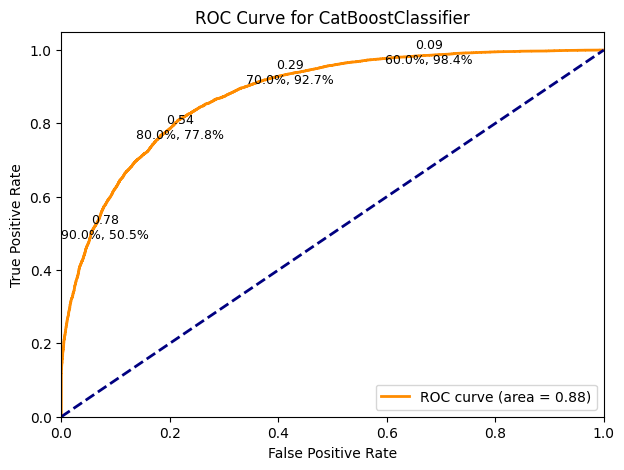

Optimal threshold for at least 70% precision: 0.29297465299112185
CatBoostClassifier - F1 Score: 79.76%, Precision: 70.0%, Recall: 92.67%, Training time: 4.29s

Model: CatBoostClassifier
  F1 Score: 79.760
  Precision: 70.000
  Recall: 92.670



In [44]:
from sklearn.preprocessing import StandardScaler
import time
from sklearn.metrics import (
    precision_recall_curve,
    f1_score,
    precision_score,
    recall_score,
    roc_curve,
)

NUMBER_FEATURES = 85

scaler = StandardScaler()


def evaluate_model(model, name, X_train, X_test, y_train, y_test):
    start = time.time()
    model.fit(X_train, y_train)

    # Predict probabilities on the test set
    y_test_probabilities = model.predict_proba(X_test)[:, 1]
    roc(y_test, y_test_probabilities, name)
    # Calculate precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_test_probabilities)

    # Filter out the thresholds where the precision is below 70%
    high_precision_indices = precision >= 0.7

    # We want to maximize recall, so we find the highest threshold that gives us at least 70% precision
    # This means we want the smallest threshold that is still greater or equal to 70% precision
    # This will be the first True in the high_precision_indices array
    max_recall_threshold_index = np.argmax(high_precision_indices)

    # Ensure we do not exceed the length of thresholds array
    optimal_threshold = (
        thresholds[max_recall_threshold_index]
        if max_recall_threshold_index < len(thresholds)
        else 1.0
    )

    print(f"Optimal threshold for at least 70% precision: {optimal_threshold}")

    # Apply the optimal threshold to get binary predictions on the test set
    y_test_pred = (y_test_probabilities >= optimal_threshold).astype(int)
    # Evaluate performance
    f1 = round(f1_score(y_test, y_test_pred) * 100, 2)
    precision = round(precision_score(y_test, y_test_pred) * 100, 2)
    recall = round(recall_score(y_test, y_test_pred) * 100, 2)

    print(
        f"{name} - F1 Score: {f1}%, Precision: {precision}%, Recall: {recall}%, Training time: {round(time.time() - start, 2)}s"
    )

    return f1, precision, recall


models = {
    "CatBoostClassifier": CatBoostClassifier(
        silent=True, random_seed=42, iterations=600
    ),
    # "AdaBoostClassifier": AdaBoostClassifier(n_estimators=600, learning_rate=0.9),
    # "RandomForestClassifier": RandomForestClassifier(n_estimators=1100,max_depth=11,max_features='sqrt', random_state=42),
    # "GradientBoostingClassifier": GradientBoostingClassifier(n_estimators=225, learning_rate=0.04, max_depth=8,max_features='sqrt',subsample=0.90),
    # "ExtraTreesClassifier": ExtraTreesClassifier(n_estimators=850, max_depth=12, max_features='sqrt', bootstrap=True),
    # "SVC": SVC(),
    # "MLPClassifier": MLPClassifier(hidden_layer_sizes=(90), random_state=42),
    # "LGBMClassifier": LGBMClassifier(num_leaves=31, max_depth=-1, learning_rate=0.1, verbose=-1),
    # "LogisticRegression": LogisticRegression(max_iter=1000),
    # "KNeighborsClassifier": KNeighborsClassifier(),
    # "GaussianNB": GaussianNB(),
    # "XGBClassifier": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
}

results = {
    name: evaluate_model(
        model,
        name,
        training_data[sorted_importance[:NUMBER_FEATURES].Feature],
        test_data[sorted_importance[:NUMBER_FEATURES].Feature],
        training_labels.values.ravel(),
        test_labels.values.ravel(),
    )
    for name, model in models.items()
}

sorted_results = dict(
    sorted(results.items(), key=lambda item: item[1][0], reverse=True)
)  # Sorting based on F1 score

print()
# Printing the results
for name, metrics in sorted_results.items():
    f1, precision, recall = metrics
    print(
        f"Model: {name}\n  F1 Score: {f1:.3f}\n  Precision: {precision:.3f}\n  Recall: {recall:.3f}\n"
    )